# Bonus1: Parallel Algorithms

### Name: Ryan Adoni


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.0770087  -0.06135287 -0.05080107 -0.01817053  0.0145686  -0.02395531
  -0.06612016 -0.0425745 ]]
test std = 
[[0.88395819 0.98696897 1.01698416 1.04436596 1.1398078  0.8708298
  0.91153163 0.94659097]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


##  Worker Node Definition

In [205]:
# Worker class defined in the pdf given to us.  Originally for AGD, I am adapting it for GD and SGD
class Worker:
    def __init__(self, x, y):
        self.x = x # s−by−d local feature matrix
        self.y = y # s−by−1 local label matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features
        self.w = numpy.zeros((d, 1)) # d−by−1 model parameter vector
        self.w0 = numpy.zeros((d, 1)) # d−by−1 model parameter vector
        self.neighbors = []

    # Set the model parameters to the latest
    def set_param(self, w, neighbors):
        self.w = w
        self.w0 = w # must add this to calculate p
        self.neighbors = neighbors
    
    # get the weights of a specific node
    def get_weights(self):
        return self.w

    # updates the paramters of a node according to its neighbors
    def update_params(self, workers, weighted, weight):
        # print(len(neighbors))
        # print(self.neighbors)
        if weighted == False:
            for i in self.neighbors:
                self.w += workers[i].get_weights()
            self.w /= (len(self.neighbors) + 1) # add one because the neighbors don't include the node itself
        else:
            w2 = 1 - weight
            self.w *= weight
            for i in self.neighbors:
                self.w += (workers[i].get_weights() * (1 / len(self.neighbors)) * w2 )

    
    # Compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(-yxw) # s−by−1 matrix
        vec2 = numpy.log(1 + vec1) # s−by−1 matrix
        return numpy.sum(vec2) # loss function
    
    # Compute the local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(yxw) # s−by−1 matrix
        vec2 = numpy.divide(yx, 1 + vec1) # s−by−d matrix
        g = -numpy.sum(vec2, axis = 0).reshape(self.d, 1) # d−by−1 matrix
        return g

    # from my hw2 with minor edits
    def gd(self, stepsize, max_iter = 100):
        for t in range(max_iter):
            self.g = self.gradient()
            self.w -= stepsize * self.g   
        return self.w, self.loss()


## Initialization

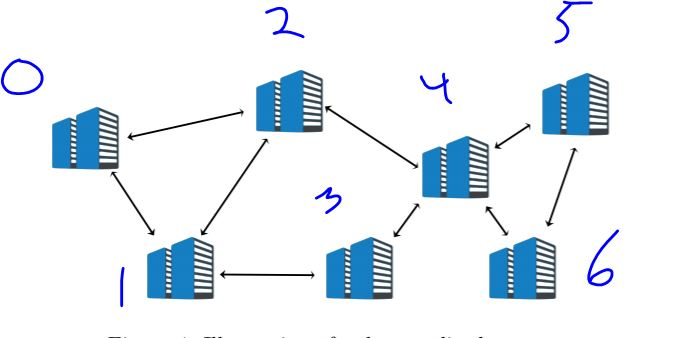

In [192]:
from IPython import display
display.Image("./network.jpg")

# this is the image I will use to tell what node I will call what node.  This will be used for me to initialize the neighbor arrays
# neighbors = [[1, 2], [0, 2, 3], [0, 1, 4], [1, 4], [2, 3, 5, 6], [4, 6], [4, 5]]

In [207]:
import math

# Create m worker nodes
def create_workers(m, x, y):
    n, d = x.shape
    s = math.floor(n / m)
    workers = []

    for i in range(m):
        indices = list(range(i * s, (i + 1) * s))
        worker = Worker(x[indices, :], y[indices, :])
        workers.append(worker)

    return workers

## Decentralized Optimization using Gradient Descent

In [213]:
def decentralized_optimization(lam, alpha, max_epoch, neighbors, x, weight, weighted = False):
    objs = []

    # step 1: 
    for i in range(m):
        workers[i].set_param(numpy.zeros((x.shape[1], 1)), neighbors[i])

    for t in range(max_epoch):

        # step 2: workers’ local computations
        grads = []
        losses = []

        for i in range(m):   
            workers[i].update_params(workers, weighted, weight)
        
        for i in range(m):
            g, l = workers[i].gd(alpha, 1)
            grads.append(g)
            losses.append(l)    
        
        # step 3: aggregate the workers’ weights and average them
        w = numpy.zeros((x.shape[1], 1)) # d−by−1 model parameter vector
        loss = 0
        g = 0
        for i in range(m):
            g += grads[i]
            loss += losses[i]
            w += workers[i].get_weights()
        w /= m

        # calulate objective value
        reg = lam / 2 * numpy.sum(w * w)
        obj = loss / x.shape[0] + reg


        # step 4: Record the model parameter
        objs.append(obj) # apend obj to list
        print("Objective function value = " + str(obj)) 
    return objs

In [218]:
lam = 1E-6 # regularization parameter
alpha = 1E-3 # learning rate
max_epoch = 100 # number of epochs
m = 7 # number of worker nodes
neighbors = [[1, 2], [0, 2, 3], [0, 1, 4], [1, 4], [2, 3, 5, 6], [4, 6], [4, 5]] # the neighbors for the specific decentralized network I am creating

# definitely could have implemented this better.  I could basically just remove the True/False and derive a formula that works always, but this seems to work.

print("GD Simple Averaging")
workers = create_workers(m, x_train, y_train)
objs_gds = decentralized_optimization(lam, alpha, max_epoch, neighbors, x_train, 1, False)

print("GD Weighted")
workers = create_workers(m, x_train, y_train)
objs_gdw = decentralized_optimization(lam, alpha, max_epoch, neighbors, x_train, 9 / 10, True)

GD Simple Averaging
Objective function value = 0.675944074898492
Objective function value = 0.664063584560022
Objective function value = 0.6532962759148288
Objective function value = 0.6434107876578977
Objective function value = 0.6342925102194819
Objective function value = 0.6258589696067449
Objective function value = 0.6180425160599446
Objective function value = 0.6107847291634235
Objective function value = 0.6040340349285631
Objective function value = 0.597744475000446
Objective function value = 0.5918749310365622
Objective function value = 0.5863885452551605
Objective function value = 0.5812522402092106
Objective function value = 0.576436301150129
Objective function value = 0.5719140062368815
Objective function value = 0.5676612975326499
Objective function value = 0.5636564883271663
Objective function value = 0.5598800031845325
Objective function value = 0.5563141474453159
Objective function value = 0.5529429031154351
Objective function value = 0.5497517482745077
Objective function

## compare simple averaging and weighted averaging

<ipython-input-219-2c4761979f59>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gds, objs_gds, '--b', LineWidth = 4)
<ipython-input-219-2c4761979f59>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_gdw, objs_gdw, '-r', LineWidth = 2)
<ipython-input-219-2c4761979f59>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Epochs', FontSize = 20)
<ipython-input-219-2c4761979f59>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Objective Value', FontSize = 20)
<ipython-input-219-2c4761979f59>:15: MatplotlibDeprecationWarning: Case-insensitive properties were depr

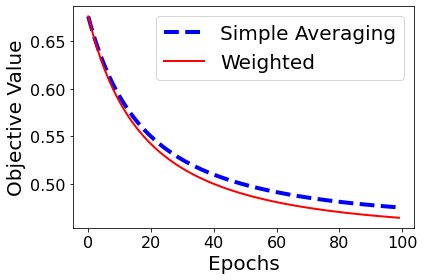

In [219]:

# copied this from hw2
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gds = range(len(objs_gds)) # weights are all seet to 1
epochs_gdw = range(len(objs_gdw)) # weights are different 

line0, = plt.plot(epochs_gds, objs_gds, '--b', LineWidth = 4)
line1, = plt.plot(epochs_gdw, objs_gdw, '-r', LineWidth = 2)

plt.xlabel('Epochs', FontSize = 20)
plt.ylabel('Objective Value', FontSize = 20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['Simple Averaging', 'Weighted'], fontsize = 20)
plt.tight_layout()
plt.show()
fig.savefig('compare.pdf', format='pdf', dpi=1200)